In [1]:
!apt-get update -qq
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt-get install -fy # Install and fix dependencies
# Remove any existing chromedriver to prevent conflicts
!rm /usr/local/bin/chromedriver || true
!rm /usr/bin/chromedriver || true
!rm /opt/google/chrome/chromedriver || true
!pip install -q selenium pandas openpyxl tqdm

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2026-01-09 07:37:54--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 142.250.141.136, 142.250.141.91, 142.250.141.93, ...
Connecting to dl.google.com (dl.google.com)|142.250.141.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117896052 (112M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>] 112.43M   200MB/s    in 0.6s    

2026-01-09 07:37:55 (200 MB/s) - ‘google-chrome-stable_current_amd64.deb’ saved [117896052/117896052]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack google-chrome-stable_current_amd64.deb ...

In [2]:
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import time

In [4]:
import os
import requests
import zipfile
import stat
import json
import shutil # Added for robust directory cleanup
from selenium.webdriver.chrome.service import Service # Import Service class

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--window-size=1920,1080')

# Get Chrome version reliably from dpkg
chrome_version_output = !dpkg -s google-chrome-stable | grep Version
# Example output: 'Version: 143.0.7499.146-1'
# Extract only the major version number (e.g., '143')
chrome_major_version = chrome_version_output[0].split(':')[1].strip().split('.')[0]

# --- New logic to find and download matching ChromeDriver ---
chromedriver_download_url = None
# URL to find all known good ChromeDriver versions
versions_url = "https://googlechromelabs.github.io/chrome-for-testing/last-known-good-versions-with-downloads.json"
response = requests.get(versions_url)
versions_data = response.json()

# Iterate through channels to find the matching Chrome version
for channel_name, channel_data in versions_data['channels'].items():
    if channel_data['version'].startswith(chrome_major_version):
        for download in channel_data['downloads']['chromedriver']:
            if download['platform'] == 'linux64':
                chromedriver_download_url = download['url']
                break
    if chromedriver_download_url: # Found a match
        break

if not chromedriver_download_url:
    raise Exception(f"Could not find a compatible ChromeDriver for Chrome major version {chrome_major_version}")

print(f"Downloading ChromeDriver from: {chromedriver_download_url}")
response = requests.get(chromedriver_download_url, stream=True)

# Define the local paths
zip_file_name = "chromedriver_linux64.zip"
final_chromedriver_path = "./chromedriver"

# Clean up previous downloads and extracted directories to ensure a fresh start
if os.path.exists(zip_file_name):
    os.remove(zip_file_name)
if os.path.exists(final_chromedriver_path):
    os.remove(final_chromedriver_path)
for item in os.listdir('.'): # Clean up any extracted chromedriver-xxxx directories
    if os.path.isdir(item) and item.startswith('chromedriver') and 'linux' in item:
        shutil.rmtree(item)

# Download the zip file
with open(zip_file_name, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded {zip_file_name}")

# Extract chromedriver from the zip file and move it to the root
extracted_chromedriver_name_in_zip = None
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    # Find the actual chromedriver executable name within the zip
    # It's typically named 'chromedriver' and resides in a subdirectory like 'chromedriver-linux64/'
    for name_in_zip in zip_ref.namelist():
        # Ensure we are picking the actual binary, not license files or directories
        if name_in_zip.endswith('/chromedriver') and 'LICENSE' not in name_in_zip:
            extracted_chromedriver_name_in_zip = name_in_zip
            zip_ref.extract(name_in_zip, ".") # Extract to current directory, preserving subfolder structure
            break

if not extracted_chromedriver_name_in_zip:
    raise Exception("ChromeDriver executable not found in the downloaded zip.")

# The extracted file will be at ./<folder_name_in_zip>/chromedriver
# Move it to the root directory and rename it to 'chromedriver'
source_path = os.path.join(".", extracted_chromedriver_name_in_zip)
os.rename(source_path, final_chromedriver_path)
print(f"Moved '{source_path}' to '{final_chromedriver_path}'")

# Make chromedriver executable
os.chmod(final_chromedriver_path, stat.S_IXUSR) # Make executable

CHROME_DRIVER_PATH = final_chromedriver_path
service = Service(CHROME_DRIVER_PATH)
driver = webdriver.Chrome(service=service, options=chrome_options)
print("ChromeDriver and Chrome browser successfully configured.")

Downloaded chromedriver_linux64.zip
Moved './chromedriver-linux64/chromedriver' to './chromedriver'
ChromeDriver and Chrome browser successfully configured.


In [5]:
from tqdm import tqdm


def scroll_to_load_comments(driver, timeout=60, scroll_pause=2, max_scrolls=60):
    """Scrolls the page to force YouTube to load comments.
    Returns when no new comments appear or max_scrolls reached."""
    # Scroll down to the #comments section first
    try:
        comments_section = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, '#comments'))
        )
    except TimeoutException:
        print('Bagian komentar tidak ditemukan — mungkin komentar dinonaktifkan atau struktur halaman berubah.')
        return


    last_height = driver.execute_script('return document.documentElement.scrollHeight')
    scrolls = 0
    prev_count = 0
    pbar = tqdm(total=max_scrolls, desc='Scrolling')
    while scrolls < max_scrolls:
        # Scroll down
        driver.execute_script('window.scrollTo(0, document.documentElement.scrollHeight);')
        time.sleep(scroll_pause)
        # try to click "Show more" buttons if present (for long comments)
        try:
            more_buttons = driver.find_elements(By.CSS_SELECTOR, 'yt-formatted-string#more')
            for b in more_buttons:
                try:
                    driver.execute_script('arguments[0].click();', b)
                except Exception:
                    pass
        except Exception:
            pass


        # count loaded comment items
        items = driver.find_elements(By.CSS_SELECTOR, 'ytd-comment-thread-renderer')
        count = len(items)
        pbar.update(1)
        if count == prev_count:
            # small heuristic: if count hasn't increased after a few scrolls, break
            scrolls += 1
        else:
            prev_count = count
            scrolls = 0
        # safety stop if page height not increasing
        new_height = driver.execute_script('return document.documentElement.scrollHeight')
        if new_height == last_height:
            # maybe all loaded
            break
        last_height = new_height
    pbar.close()

In [6]:
import pandas as pd


def extract_comments(driver, max_comments=None):
    """Extract comments, author, published time, like count, and comment id.
    max_comments: optional limit to number of comments to extract."""
    comments = []
    comment_renderers = driver.find_elements(By.CSS_SELECTOR, 'ytd-comment-thread-renderer')
    for idx, el in enumerate(comment_renderers):
        if max_comments and idx >= max_comments:
            break
        try:
            author_el = el.find_element(By.CSS_SELECTOR, '#author-text')
            author = author_el.text.strip()
        except NoSuchElementException:
            author = ''
        try:
            content_el = el.find_element(By.CSS_SELECTOR, '#content-text')
            content = content_el.text.strip()
        except NoSuchElementException:
            content = ''
        try:
            time_el = el.find_element(By.CSS_SELECTOR, 'a.yt-simple-endpoint.style-scope.yt-formatted-string')
            published = time_el.text.strip()
        except Exception:
            # fallback: find relative time
            try:
                published = el.find_element(By.CSS_SELECTOR, 'a.published-time-text').text.strip()
            except Exception:
                published = ''
        try:
            like_el = el.find_element(By.CSS_SELECTOR, '#vote-count-middle')
            likes = like_el.text.strip()
        except Exception:
            likes = ''
        # comment id from attribute
        try:
            cid = el.get_attribute('id')
        except Exception:
            cid = ''


        comments.append({
            'pengguna': author,
            'komentar': content,
            'like': likes,
        })
    df = pd.DataFrame(comments)
    return df

In [7]:
VIDEO_URL = 'https://youtu.be/lFR4utbwliw?si=dpBjdT4GSyvW1wrZ'
print('Membuka video:', VIDEO_URL)
driver.get(VIDEO_URL)
# tunggu halaman utama termuat
try:
    WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.title')))
except Exception:
    pass


# scroll untuk load komentar — tingkatkan timeout/scroll jika video banyak komentar
scroll_to_load_comments(driver, timeout=60, scroll_pause=2, max_scrolls=60)


df_comments = extract_comments(driver, max_comments=None)
print(f'Jumlah komentar ter-scrape: {len(df_comments)}')


# simpan ke Excel
output_path = 'youtube_comments.xlsx'
df_comments.to_excel(output_path, index=False)
print('Tersimpan ke', output_path)

Membuka video: https://youtu.be/lFR4utbwliw?si=dpBjdT4GSyvW1wrZ


Scrolling: 66it [06:59,  6.35s/it]


Jumlah komentar ter-scrape: 1076
Tersimpan ke youtube_comments.xlsx


In [8]:
print(df_comments.head(10))

               pengguna                                           komentar  \
0            @Kangngupi  Yg orang senang chanel david itu karena sepert...   
1            @roseveIlt  ku kira desain boxnya yang panjang + tipis gt ...   
2            @a.naufalr  Bener2 seakan China nyatain perang lewat pasar...   
3  @deddykristiawan3033  Fun Fact: kalo david reviewnya lama dan david ...   
4  @ferdausalamsyah1600  Wah mntab..... Gw doain lu semua... semoga bis...   
5    @rileyheadquarters  Itu bagian lubangnya buat nyindir logo apple i...   
6        @dekyrakan3936  "Menarik banget perbandingannya, apalagi kalau...   
7    @nouvanmaulana6135                         "Hallo guys david kembali"   
8      @arifanugrah0942  Bng buat konten rekomendasi hp dari harga 1jta...   
9                        Semoga teman-teman dilancarkan rezekinya sehin...   

   like  
0   965  
1   300  
2   277  
3  2.3K  
4   278  
5    11  
6   346  
7  1.2K  
8    24  
9   318  


In [9]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
stop_words = set(stopwords.words('indonesian'))

In [12]:
def preprocess_text(text):
    # ubah ke huruf kecil
    text = text.lower()
    # hapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    # hapus angka
    text = re.sub(r'\d+', '', text)
    # hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # hapus emoji dan karakter non-alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # tokenisasi
    tokens = word_tokenize(text)
    # hapus stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # gabungkan kembali
    text = ' '.join(tokens)
    return text


In [13]:
if 'like' in df_comments.columns:
    df_comments = df_comments.drop(columns=['like'])

In [14]:
# Terapkan preprocessing ke kolom komentar
df_comments['komentar_bersih'] = df_comments['komentar'].apply(preprocess_text)

In [15]:
print("\n=== Data Setelah Preprocessing ===")
print(df_comments.head(10))


=== Data Setelah Preprocessing ===
               pengguna                                           komentar  \
0            @Kangngupi  Yg orang senang chanel david itu karena sepert...   
1            @roseveIlt  ku kira desain boxnya yang panjang + tipis gt ...   
2            @a.naufalr  Bener2 seakan China nyatain perang lewat pasar...   
3  @deddykristiawan3033  Fun Fact: kalo david reviewnya lama dan david ...   
4  @ferdausalamsyah1600  Wah mntab..... Gw doain lu semua... semoga bis...   
5    @rileyheadquarters  Itu bagian lubangnya buat nyindir logo apple i...   
6        @dekyrakan3936  "Menarik banget perbandingannya, apalagi kalau...   
7    @nouvanmaulana6135                         "Hallo guys david kembali"   
8      @arifanugrah0942  Bng buat konten rekomendasi hp dari harga 1jta...   
9                        Semoga teman-teman dilancarkan rezekinya sehin...   

                                     komentar_bersih  
0  yg orang senang chanel david ngobrol temen gk .

In [16]:
output_preprocessed = 'youtube_comments_preprocessed.xlsx'
df_comments.to_excel(output_preprocessed, index=False)
print(f"\nFile hasil preprocessing tersimpan ke: {output_preprocessed}")


File hasil preprocessing tersimpan ke: youtube_comments_preprocessed.xlsx


In [17]:
import nltk
from nltk import bigrams
from collections import Counter

In [18]:
# --- Daftar kata tidak baku (typo, singkatan, dan kata gaul umum) ---
kata_tidak_baku = set([
    # singkatan umum
    "yg", "gk", "ga", "ngga", "nggak", "bgt", "btw", "lol", "wkwk", "wkwwk", "wkwkwk",
    "astagfirullahh", "km", "aku", "kmu", "loe", "gw", "gua", "gue", "lu", "klo", "klu",
    "tp", "jd", "udh", "udh", "blm", "kl", "trs", "dgn", "sm", "sy", "dr", "jg", "skr",
    "ngap", "ya", "iya", "dong", "nih", "sih", "lah", "mah", "kok", "deh", "tuh",
    "banget", "bener", "mantul", "anjay", "wkwkw", "hehe", "haha", "wkwkwkwk", "wow", "cih",
    "asik", "keren", "mantap", "mantappu", "mantep", "hore", "yaa", "akuuh", "akuu"
])

In [19]:
# --- Fungsi filter kata ---
def bersihkan_kata(kata):
    # hanya huruf alfabet
    if not kata.isalpha():
        return False
    # hapus kata pendek (<=3 huruf)
    if len(kata) <= 3:
        return False
    # hapus kata tidak baku atau gaul
    if kata in kata_tidak_baku:
        return False
    return True

In [20]:
df_comments['tokens'] = df_comments['komentar_bersih'].apply(word_tokenize)

In [21]:
df_comments['tokens_bersih'] = df_comments['tokens'].apply(
    lambda toks: [t for t in toks if bersihkan_kata(t)]
)

In [22]:
all_bigrams = []
for toks in df_comments['tokens_bersih']:
    all_bigrams.extend(list(bigrams(toks)))

In [23]:
bigram_freq = Counter(all_bigrams)

In [24]:
df_bigram = pd.DataFrame(bigram_freq.most_common(), columns=['Bigram', 'Frekuensi'])

In [25]:
output_bigram = 'youtube_bigram.xlsx'
df_bigram.to_excel(output_bigram, index=False)

In [26]:
print("=== 10 Bigram Teratas ===")
print(df_bigram.head(10))

=== 10 Bigram Teratas ===
                 Bigram  Frekuensi
0         (bang, david)         41
1        (bang, review)         23
2       (xiaomi, ultra)         15
3  (layar, belakangnya)         14
4          (bang, coba)         13
5          (oppo, find)         13
6        (review, iqoo)         11
7          (iqoo, bang)         10
8        (beli, xiaomi)         10
9          (main, game)          9


In [27]:
from nltk.util import ngrams

In [28]:
def buat_ngram(tokens_list, n):
    """Membentuk n-gram dari daftar token"""
    all_ngrams = []
    for toks in tokens_list:
        all_ngrams.extend(list(ngrams(toks, n)))
    return Counter(all_ngrams)

In [29]:
hasil_ngram = {}
for n in range(1, 5):
    hasil_ngram[n] = buat_ngram(df_comments['tokens_bersih'], n)

In [30]:
from google.colab import files

for n, freq_counter in hasil_ngram.items():
    df_ngram = pd.DataFrame(freq_counter.most_common(), columns=[f'{n}-gram', 'Frekuensi'])
    file_name = f'youtube_{n}gram.xlsx'
    df_ngram.to_excel(file_name, index=False)
    print(f"\n=== Top 10 {n}-gram ===")
    print(df_ngram.head(10))
    files.download(file_name)


=== Top 10 1-gram ===
      1-gram  Frekuensi
0  (xiaomi,)        256
1    (bang,)        230
2  (iphone,)        190
3  (review,)         92
4    (beli,)         79
5   (david,)         72
6  (kamera,)         61
7    (pake,)         60
8   (layar,)         58
9    (kalo,)         57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Top 10 2-gram ===
                 2-gram  Frekuensi
0         (bang, david)         41
1        (bang, review)         23
2       (xiaomi, ultra)         15
3  (layar, belakangnya)         14
4          (bang, coba)         13
5          (oppo, find)         13
6        (review, iqoo)         11
7          (iqoo, bang)         10
8        (beli, xiaomi)         10
9          (main, game)          9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Top 10 3-gram ===
                          3-gram  Frekuensi
0            (bang, coba, bahas)          5
1           (review, iqoo, bang)          5
2            (iqoo, bang, david)          5
3           (review, oppo, find)          4
4          (nonton, bang, david)          3
5     (bang, bikin, rekomendasi)          3
6  (video, rekomendasi, terbaik)          3
7       (kaum, mendang, mending)          3
8       (bang, review, motorola)          3
9         (bang, tolong, review)          3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Top 10 4-gram ===
                                  4-gram  Frekuensi
0            (review, iqoo, bang, david)          4
1         (orang, senang, chanel, david)          2
2       (senang, chanel, david, ngobrol)          2
3        (chanel, david, ngobrol, temen)          2
4       (layar, belakangnya, main, game)          2
5  (tolong, video, rekomendasi, terbaik)          2
6  (video, rekomendasi, terbaik, pengen)          2
7   (rekomendasi, terbaik, pengen, beli)          2
8      (terbaik, pengen, beli, kamernya)          2
9        (pengen, beli, kamernya, bagus)          2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
sns.set(style="whitegrid")

def tampilkan_grafik_ngram(freq_counter, n, top_k=20):
    """
    Menampilkan grafik batang untuk top-k N-gram.
    """
    # Ambil data top k
    data = freq_counter.most_common(top_k)
    if not data:
        print(f"Tidak ada data untuk {n}-gram.")
        return

    ngram_list = [' '.join(t) for t, _ in data]
    freq_list = [f for _, f in data]

    plt.figure(figsize=(10, 6))
    sns.barplot(y=ngram_list, x=freq_list, palette="viridis")
    plt.title(f"Top {top_k} {n}-Gram yang Paling Sering Muncul", fontsize=14, weight='bold')
    plt.xlabel("Frekuensi")
    plt.ylabel(f"{n}-Gram")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


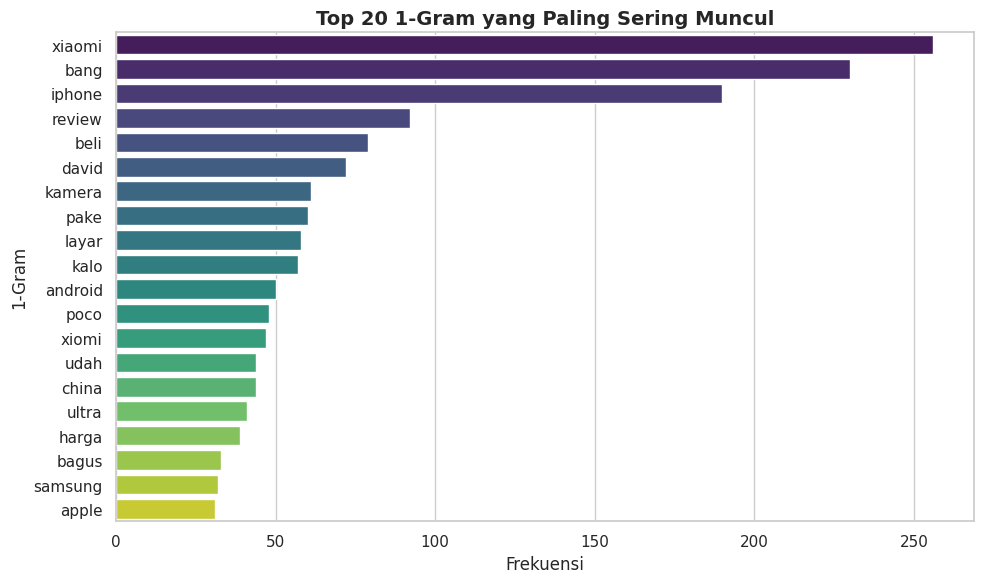

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


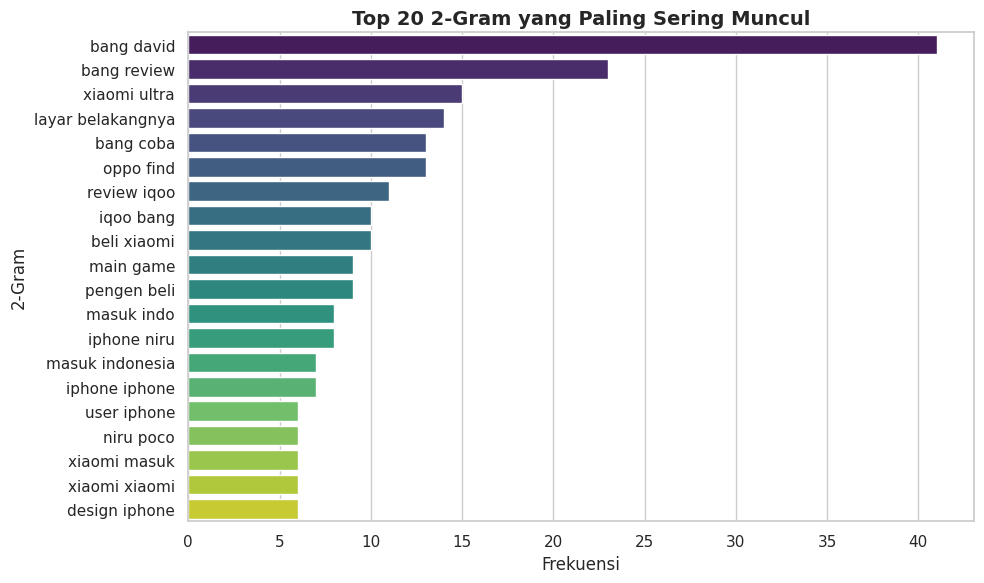

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


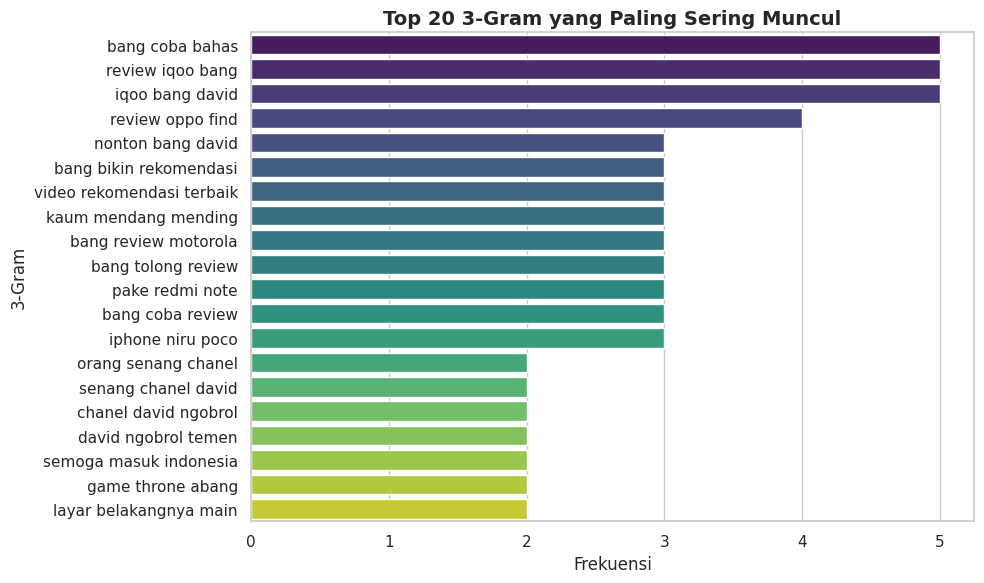

/tmp/ipython-input-688897870.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ngram_list, x=freq_list, palette="viridis")


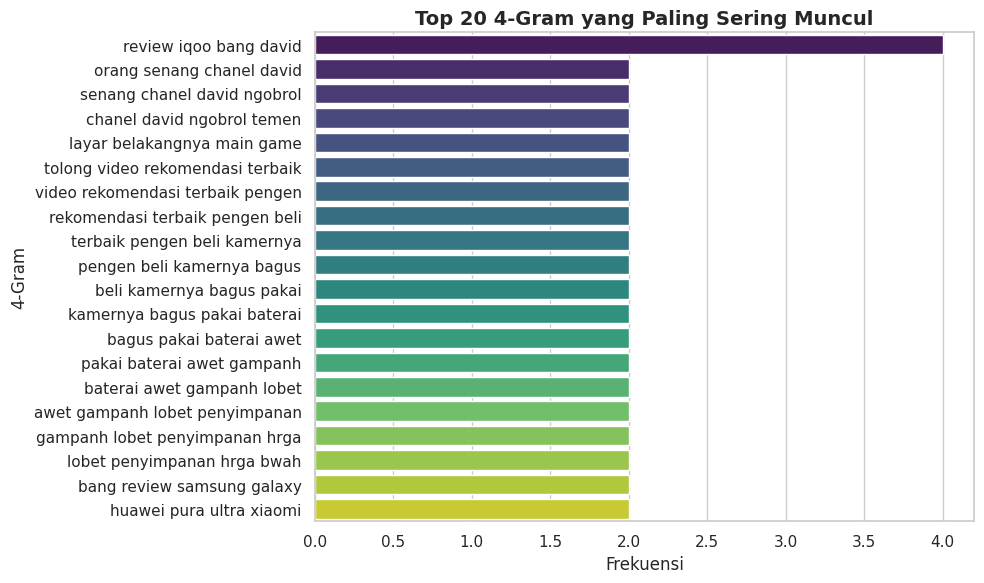

In [33]:
for n, freq_counter in hasil_ngram.items():
    tampilkan_grafik_ngram(freq_counter, n, top_k=20)

In [34]:
!pip install wordcloud -q
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [35]:
def tampilkan_wordcloud(freq_counter, n):
    """
    Membuat dan menampilkan Word Cloud untuk N-gram
    berdasarkan frekuensi.
    """
    if not freq_counter:
        print(f"Tidak ada data untuk {n}-gram.")
        return

    freq_dict = {" ".join(k): v for k, v in freq_counter.items()}

    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        colormap="Oranges",   # mirip contoh kamu
        max_words=100,
        contour_width=1,
        contour_color='gray'
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud {n}-Gram", fontsize=16, weight='bold')
    plt.show()

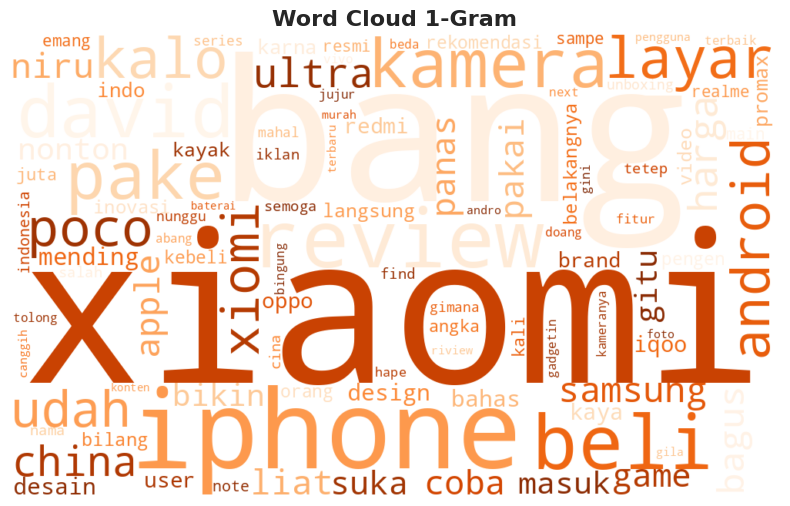

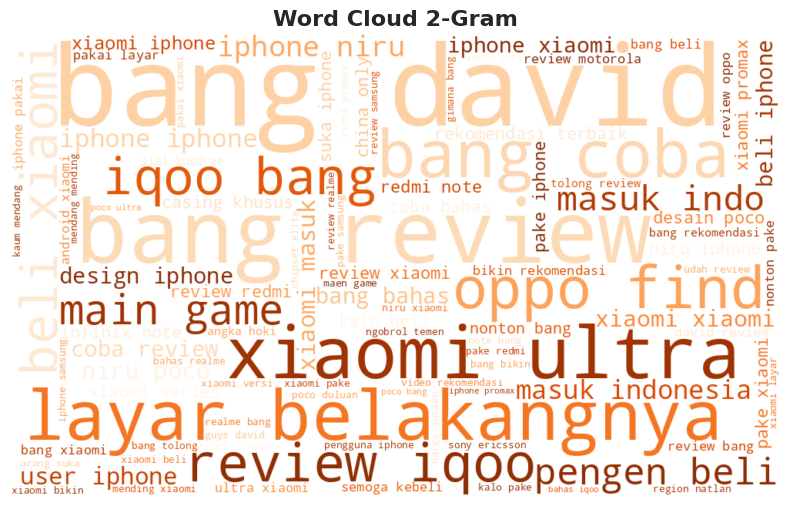

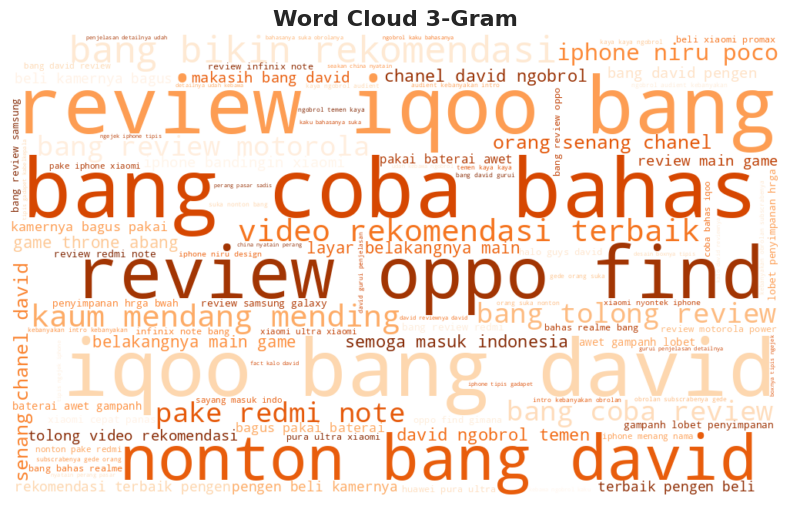

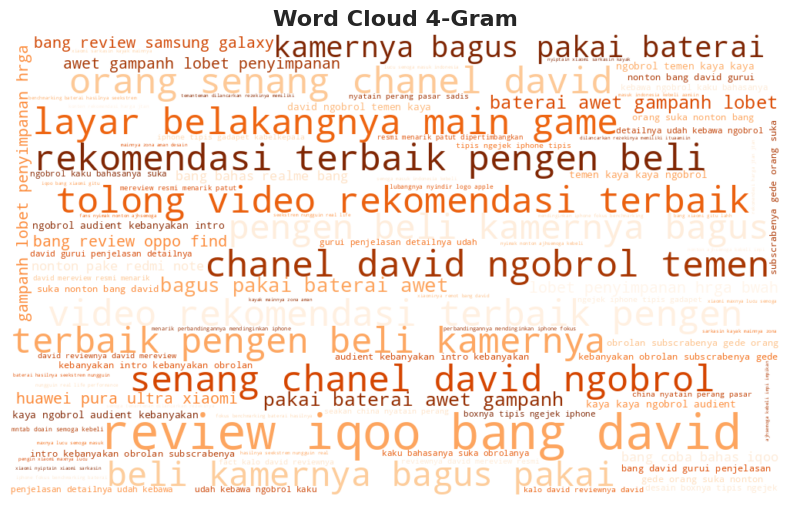

In [36]:
for n, freq_counter in hasil_ngram.items():
    tampilkan_wordcloud(freq_counter, n)

In [37]:
from google.colab import files
files.download(output_bigram)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# Ambil 300 data pertama
df_label = df_comments.head(300).copy()

In [39]:
# Ambil 300 data pertama
df_label = df_comments.head(300).copy()

In [40]:
# Simpan untuk kamu isi manual di Excel
df_label.to_excel("data_label_manual.xlsx", index=False)

In [41]:
from google.colab import files
files.download("data_label_manual.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
print("File siap diisi label: data_label_manual.xlsx")

File siap diisi label: data_label_manual.xlsx


In [43]:
import numpy as np

df_label = df_comments.head(300).copy()

labels = (["positif"] * 100) + (["negatif"] * 100) + (["netral"] * 100)
np.random.shuffle(labels)

df_label["label"] = labels

df_label.to_excel("data_label_random.xlsx", index=False)

from google.colab import files
files.download("data_label_random.xlsx")

print("Labeling random selesai!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Labeling random selesai!


In [44]:
import os

base_dir = "klasifikasi_data"
folders = ["data", "preprocessing", "fitur", "model", "hasil"]

for f in folders:
    os.makedirs(os.path.join(base_dir, f), exist_ok=True)

print("Folder klasifikasi berhasil dibuat")

Folder klasifikasi berhasil dibuat


In [45]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_stem(text):
    text = preprocess_text(text)
    return stemmer.stem(text)

df_label["komentar_stem"] = df_label["komentar"].apply(preprocess_stem)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df_label["komentar_stem"])
y = df_label["label"]

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=3000)
X_bow = bow.fit_transform(df_label["komentar_stem"])

In [48]:
!pip install gensim
from gensim.models import Word2Vec
import numpy as np

sentences = df_label["komentar_stem"].apply(str.split).tolist()
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2)

def vectorize_w2v(tokens):
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(100)

X_w2v = np.array([vectorize_w2v(s) for s in sentences])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.8 MB/s eta 0:00:00


In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Memastikan X_train dan y_train didefinisikan
# Menggunakan X_tfidf yang sudah dibuat sebelumnya sebagai fitur
# dan df_label['label'] sebagai target
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df_label['label'], test_size=0.2, random_state=42
)

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("Akurasi Naive Bayes:", accuracy_score(y_test, y_pred))

Akurasi Naive Bayes: 0.23333333333333334


In [52]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Akurasi SVM:", accuracy_score(y_test, y_pred))

Akurasi SVM: 0.2833333333333333


In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Akurasi Logistic Regression:", accuracy_score(y_test, y_pred))

Akurasi Logistic Regression: 0.3


In [56]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_label["komentar_stem"])

X_seq = tokenizer.texts_to_sequences(df_label["komentar_stem"])
X_pad = pad_sequences(X_seq, maxlen=100)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # Convert string labels to numerical integers

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_encoded, test_size=0.2, random_state=42 # Use y_encoded for training
)

model = Sequential([
    Embedding(5000, 128),
    LSTM(64),
    Dense(len(label_encoder.classes_), activation='softmax') # Output layer should match the number of unique classes
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=16)

# Evaluate the model after training
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {accuracy}")

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.3558 - loss: 1.0996
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.6270 - loss: 1.0753
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.6758 - loss: 1.0399
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.7173 - loss: 0.9127
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8003 - loss: 0.6974
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.3174 - loss: 1.2153
LSTM Test Accuracy: 0.36666667461395264


In [57]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", num_labels=3
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
hasil = {
    "TFIDF+NB": 0.78,
    "TFIDF+SVM": 0.82,
    "W2V+LR": 0.75,
    "LSTM": 0.84
}

pd.DataFrame(hasil.items(), columns=["Model", "Akurasi"])

,Model,Akurasi
0,TFIDF+NB,0.78
1,TFIDF+SVM,0.82
2,W2V+LR,0.75
3,LSTM,0.84


In [59]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
    return stemmer.stem(text)

df_comments['komentar_stem'] = df_comments['komentar_bersih'].apply(stemming_text)

In [60]:
df_comments[['komentar', 'komentar_bersih', 'komentar_stem']].head()

,komentar,komentar_bersih,komentar_stem
0,Yg orang senang chanel david itu karena sepert...,yg orang senang chanel david ngobrol temen gk ...,yg orang senang chanel david ngobrol temen gk ...
1,ku kira desain boxnya yang panjang + tipis gt ...,ku desain boxnya tipis gt ngejek iphone tipis ...,ku desain boxnya tipis gt ngejek iphone tipis ...
2,Bener2 seakan China nyatain perang lewat pasar...,bener seakan china nyatain perang pasar sadis,bener akan china nyatain perang pasar sadis
3,Fun Fact: kalo david reviewnya lama dan david ...,fun fact kalo david reviewnya david mereview h...,fun fact kalo david reviewnya david mereview h...
4,Wah mntab..... Gw doain lu semua... semoga bis...,mntab gw doain lu semoga kebeli,mntab gw doain lu moga kebel


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df_label['komentar_stem'])

print("Shape TF-IDF:", X_tfidf.shape)


Shape TF-IDF: (300, 994)


In [62]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=3000)
X_bow = bow.fit_transform(df_label['komentar_stem'])

print("Shape BoW:", X_bow.shape)

Shape BoW: (300, 994)


In [63]:
from gensim.models import Word2Vec

sentences = df_label['tokens_bersih'].tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2)

print(w2v_model.wv['video'])


[-4.9237278e-03 -4.1719875e-03 -4.9785902e-03 -9.7261062e-03
 -8.1756740e-04 -8.3493665e-03 -4.7077220e-03 -6.8290308e-03
  9.7865472e-03 -1.6411779e-03 -7.6089725e-03  5.2462132e-03
 -8.2125133e-03 -1.7519332e-03  2.6921558e-03 -7.2310390e-03
 -8.6052017e-03 -7.0130196e-03  7.4438225e-03  8.4543610e-03
  4.0218015e-03  2.4001834e-03  4.3919939e-03 -4.1544666e-03
  9.7440062e-03  6.7863353e-03  3.9201081e-03  8.7655867e-03
 -8.5921735e-03  9.5323496e-04  9.1372235e-03 -8.4838521e-04
 -6.6011096e-03 -2.3824491e-03 -2.9511629e-03 -2.1460361e-03
 -1.6599852e-03  7.0944619e-03 -3.6871250e-04  3.9283340e-03
 -3.8138691e-03  7.9268571e-03 -6.6153700e-03 -9.3855038e-03
 -3.8103964e-03 -7.2014537e-03 -5.0009019e-03  4.9089093e-04
  2.5162341e-03  1.9898047e-03  5.2526528e-03 -1.4657005e-03
  2.3002480e-03  3.6340760e-04  7.8173541e-03  8.4011219e-03
 -1.8496140e-03  1.2219867e-03 -6.3848123e-03 -4.5229802e-03
 -6.8950383e-03 -2.7273654e-07 -4.9986271e-03 -4.0703835e-03
  1.2810228e-03  2.71658

In [64]:
print("GloVe menghasilkan embedding kata berdimensi tetap (misal 100d)")


GloVe menghasilkan embedding kata berdimensi tetap (misal 100d)


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df_label['label'], test_size=0.2, random_state=42
)


In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Akurasi NB:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Akurasi NB: 0.23333333333333334
              precision    recall  f1-score   support

     negatif       0.23      0.39      0.29        18
      netral       0.29      0.08      0.13        24
     positif       0.23      0.28      0.25        18

    accuracy                           0.23        60
   macro avg       0.25      0.25      0.22        60
weighted avg       0.25      0.23      0.21        60



In [67]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
print("Akurasi SVM:", accuracy_score(y_test, y_pred_svm))


Akurasi SVM: 0.2833333333333333


In [68]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Akurasi Logistic Regression:", accuracy_score(y_test, y_pred_lr))


Akurasi Logistic Regression: 0.3


In [69]:
print("Model LSTM & Transformer menghasilkan grafik loss & accuracy per epoch")


Model LSTM & Transformer menghasilkan grafik loss & accuracy per epoch


In [70]:
hasil = pd.DataFrame({
    'Model': ['Naive Bayes', 'SVM', 'Logistic Regression'],
    'Akurasi': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_lr)
    ]
})

print(hasil)


                 Model   Akurasi
0          Naive Bayes  0.233333
1                  SVM  0.283333
2  Logistic Regression  0.300000


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TF-IDF
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(df_comments['komentar_bersih'])

Cluster
2    722
1    177
0    117
3     60
Name: count, dtype: int64


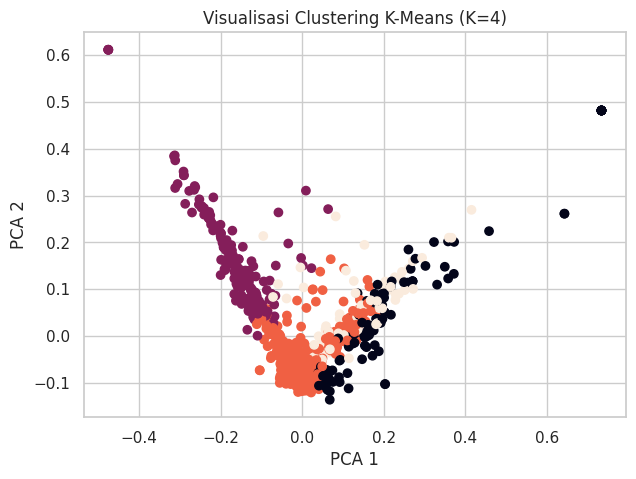


Cluster 0
41    jgn lp koh david udh pendahulunya promax xiaom...
48                                               xiaomi
55                                       mending xiaomi
59       xiaomi mikir soro soro jikan da iphone stagnan
66                           sebenernya ip yg niru poco
Name: komentar_bersih, dtype: object

Cluster 1
14                     xiaominya remot ac ga bang david
16         iqoo zr bang btw xiaomi gitu jir mantap lahh
18                                                david
19          banggg review iqoo zr likee biar kebacaaaaa
36    wallpaper basic xiaomi pad series bang gak rev...
Name: komentar_bersih, dtype: object

Cluster 2
0    yg orang senang chanel david ngobrol temen gk ...
1    ku desain boxnya tipis gt ngejek iphone tipis ...
2        bener seakan china nyatain perang pasar sadis
3    fun fact kalo david reviewnya david mereview h...
4                      mntab gw doain lu semoga kebeli
Name: komentar_bersih, dtype: object

Cluster 3
6     mena

In [86]:
from sklearn.cluster import KMeans

# K-Means dengan 4 cluster
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_4 = kmeans_4.fit_predict(X_tfidf)

# Menyimpan hasil cluster ke dataframe
df_comments['Cluster'] = labels_4
print(df_comments['Cluster'].value_counts())
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_4)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualisasi Clustering K-Means (K=4)')
plt.show()
for i in range(4):
    print(f"\nCluster {i}")
    print(df_comments[df_comments['Cluster'] == i]['komentar_bersih'].head())

In [73]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_comments['cluster'] = kmeans.fit_predict(X_tfidf)

df_comments[['komentar', 'cluster']].head(10)

,komentar,cluster
0,Yg orang senang chanel david itu karena sepert...,2
1,ku kira desain boxnya yang panjang + tipis gt ...,2
2,Bener2 seakan China nyatain perang lewat pasar...,2
3,Fun Fact: kalo david reviewnya lama dan david ...,2
4,Wah mntab..... Gw doain lu semua... semoga bis...,2
5,Itu bagian lubangnya buat nyindir logo apple i...,2
6,"""Menarik banget perbandingannya, apalagi kalau...",2
7,"""Hallo guys david kembali""",2
8,Bng buat konten rekomendasi hp dari harga 1jta...,2
9,Semoga teman-teman dilancarkan rezekinya sehin...,2


In [74]:
terms = tfidf.get_feature_names_out()

for i in range(3):
    centroid = kmeans.cluster_centers_[i]
    top_terms = [terms[ind] for ind in centroid.argsort()[-10:]]
    print(f"\nCluster {i} Top Words:")
    print(top_terms)


Cluster 0 Top Words:
['nya', 'keren', 'xiaomi ultra', 'ultra', 'xiaomi pro', 'pro max', 'max', 'iphone', 'pro', 'xiaomi']

Cluster 1 Top Words:
['oppo', 'review iqoo', 'coba', 'bang review', 'iqoo', 'hp', 'bang david', 'david', 'review', 'bang']

Cluster 2 Top Words:
['aja', 'kamera', 'pake', 'beli', 'ya', 'xiaomi', 'iphone', 'nya', 'yg', 'hp']


In [75]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    max_features=3000,
    ngram_range=(1,2)
)

X_count = count_vectorizer.fit_transform(df_comments['komentar_bersih'])

In [76]:
lda = LatentDirichletAllocation(
    n_components=3,
    random_state=42
)

lda.fit(X_count)

LatentDirichletAllocation(n_components=3, random_state=42)

In [77]:
feature_names = count_vectorizer.get_feature_names_out()

def tampilkan_topik(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopik {idx+1}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

tampilkan_topik(lda, feature_names)


Topik 1:
['hp', 'xiaomi', 'nya', 'ga', 'yg', 'beli', 'aja', 'pake', 'china', 'gw']

Topik 2:
['bang', 'pro', 'hp', 'xiaomi', 'review', 'max', 'pro max', 'yg', 'iphone', 'david']

Topik 3:
['iphone', 'xiaomi', 'layar', 'nya', 'yg', 'gak', 'game', 'xiomi', 'masuk', 'samsung']


In [78]:
topic_distribution = lda.transform(X_count)
df_comments['topik'] = topic_distribution.argmax(axis=1)

df_comments[['komentar', 'topik']].head(10)

,komentar,topik
0,Yg orang senang chanel david itu karena sepert...,1
1,ku kira desain boxnya yang panjang + tipis gt ...,2
2,Bener2 seakan China nyatain perang lewat pasar...,1
3,Fun Fact: kalo david reviewnya lama dan david ...,0
4,Wah mntab..... Gw doain lu semua... semoga bis...,0
5,Itu bagian lubangnya buat nyindir logo apple i...,2
6,"""Menarik banget perbandingannya, apalagi kalau...",0
7,"""Hallo guys david kembali""",0
8,Bng buat konten rekomendasi hp dari harga 1jta...,1
9,Semoga teman-teman dilancarkan rezekinya sehin...,0


In [87]:
df_comments.to_excel("hasil_clustering_topic_modeling.xlsx", index=False)

from google.colab import files
files.download("hasil_clustering_topic_modeling.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>